In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor 
from scipy.stats import skew, kurtosis
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import optuna
from lightgbm import plot_importance
from scipy.stats import entropy
from scipy.signal import welch
from scipy.fftpack import fft
from sklearn.preprocessing import StandardScaler

In [2]:
def get_freq_features(x,col):
    
    fft_vals = np.abs(fft(x))
    fft_freqs = np.fft.fftfreq(len(fft_vals))
    dominant_freq = fft_freqs[np.argmax(fft_vals)]
    fft_mean = np.mean(fft_vals)
    fft_std = np.std(fft_vals)
    fft_max = np.max(fft_vals)
    freqs, psd = welch(x)
    psd_mean = np.mean(psd)
    psd_max = np.max(psd)
    psd_norm = psd / np.sum(psd)
    spectral_entropy = entropy(psd_norm)
    spectral_centroid = np.sum(freqs * psd) / np.sum(psd)
    spectral_bandwidth = np.sqrt(np.sum(((freqs - spectral_centroid) ** 2) * psd) / np.sum(psd))
    spectral_rolloff = freqs[np.where(np.cumsum(psd) >= 0.85 * np.sum(psd))[0][0]]

    feature_dict = {}
    feature_dict[col+'_dominant_freq'] = dominant_freq
    feature_dict[col+'_fft_mean'] = fft_mean
    feature_dict[col+'_fft_std'] = fft_std
    feature_dict[col+'_fft_max'] = fft_max
    feature_dict[col+'_psd_mean'] = psd_mean
    feature_dict[col+'_psd_max'] = psd_max
    feature_dict[col+'_spectral_entropy'] = spectral_entropy
    feature_dict[col+'_spectral_centroid'] = spectral_centroid
    feature_dict[col+'_spectral_bandwidth'] = spectral_bandwidth
    feature_dict[col+'_spectral_rolloff'] = spectral_rolloff

    return feature_dict

In [3]:
data_pd = pd.read_parquet("data_trimmed.parquet")

data_pd['magnitude_acc'] = np.sqrt(data_pd['acc_x']**2+data_pd['acc_y']**2+data_pd['acc_z']**2)
data_pd['magnitude_gy'] = np.sqrt(data_pd['gy_x']**2+data_pd['gy_y']**2+data_pd['gy_z']**2)
data_pd['magnitude_mag'] = np.sqrt(data_pd['mag_x']**2+data_pd['mag_y']**2+data_pd['mag_z']**2)

data_pd['genre_coded'] = data_pd['genre'].astype('category').cat.codes

sensor_cols = ['acc_x','acc_y','acc_z','magnitude_acc','gy_x','gy_y','gy_z','magnitude_gy','mag_x','mag_y','mag_z','magnitude_mag']

sensor_cols_raw = ['acc_x','acc_y','acc_z','gy_x','gy_y','gy_z','mag_x','mag_y','mag_z']

In [ ]:
scaled_pd = []
for id in data_pd['subject_id'].unique():
    filtered_pd = data_pd[data_pd['subject_id']==id]
    for col in sensor_cols:
        scaler = StandardScaler()
        col_scaled = scaler.fit_transform(filtered_pd[col].values.reshape(-1,1))
        filtered_pd[col] = col_scaled.reshape(-1)
    scaled_pd.append(filtered_pd)

scaled_pd = pd.concat(scaled_pd)

data_list = scaled_pd.groupby(['subject_id','label','genre_coded'])[['acc_x','acc_y','acc_z','magnitude_acc','gy_x','gy_y','gy_z','magnitude_gy','mag_x','mag_y','mag_z','magnitude_mag']].agg(list).reset_index()

In [5]:
tmp = data_pd.groupby(['subject_id','label','genre_coded'])[['acc_x','acc_y','acc_z','magnitude_acc','gy_x','gy_y','gy_z','magnitude_gy','mag_x','mag_y','mag_z','magnitude_mag']].agg(list).reset_index()

freq_features = []

for col in sensor_cols_raw:
    data_list[col+'_diff1'] = data_list[col].apply(lambda x: np.roll(x,-1)[:-1] - np.array(x)[:-1])
    data_list[col+'_diff2'] = data_list[col+'_diff1'].apply(lambda x: np.roll(x,-1)[:-1] - np.array(x)[:-1])
    sensor_cols += [col+'_diff1',col+'_diff2']
    freq_features_pd = pd.DataFrame(data_list[col].apply(lambda x: get_freq_features(x,col)).tolist())
    freq_features.append(freq_features_pd)

data_list = pd.concat([data_list]+freq_features,axis=1)

In [ ]:
for col in sensor_cols:
    data_list[col+'_mean'] = data_list[col].apply(lambda x: np.mean(x))
    data_list[col+'_std'] = data_list[col].apply(lambda x: np.std(x))
    data_list[col+'_min'] = data_list[col].apply(lambda x: np.min(x))
    data_list[col+'_max'] = data_list[col].apply(lambda x: np.max(x))
    data_list[col+'_range'] = data_list[col].apply(lambda x: np.max(x)-np.min(x))
    data_list[col+'_skew'] = data_list[col].apply(lambda x: skew(x))
    data_list[col+'_kurtosis'] = data_list[col].apply(lambda x: kurtosis(x))

In [7]:
model_data = data_list.drop(sensor_cols,axis=1)

subject_ids = data_list.subject_id.unique()

In [8]:
def objective(trial):
    
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 20, 200, step=10),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200,step=10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 10),
        'max_depth': trial.suggest_int('max_depth', 8, 32),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.25,step=0.01),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 10, step=1),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 10, step=1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0,step=0.05),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0,step=0.05),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.01, 0.1,step=0.01)
    }

    feature_cols = model_data.drop(['subject_id','label','genre_coded'],axis=1).columns
    selected_features = []
    for col in feature_cols:
        if trial.suggest_int(col, 0, 1) == 1:
            selected_features.append(col)
    if len(selected_features) == 0:
        selected_features = [feature_cols[0]]


    cv_scores = []

    for val_subject in subject_ids:

        model = LGBMClassifier(objective='multiclass',num_class=4,**param_grid,verbose=-1)

        cv_train = model_data[model_data['subject_id']!=val_subject]
        cv_test = model_data[model_data['subject_id']==val_subject]

        X_train = cv_train[selected_features]
        X_test = cv_test[selected_features]
        y_train, y_test = cv_train['genre_coded'], cv_test['genre_coded']

        model.fit(X_train,y_train)
        preds = model.predict(X_test)
        #score = f1_score(preds,y_test,average='weighted')
        score = accuracy_score(preds,y_test)
        cv_scores.append(score)
    
    
    return np.mean(cv_scores)

In [ ]:
study = optuna.create_study(study_name="lightgbm", direction="maximize")
study.optimize(objective, n_trials=200)

In [10]:
best_params = {k:v for k,v in list(study.best_params.items())[:11]}
selected_cols = [col for col,select in list(study.best_params.items())[11:] if select==1]
print(study.best_value)
best_params

0.9166666666666666


{'n_estimators': 120,
 'num_leaves': 70,
 'min_data_in_leaf': 6,
 'max_depth': 32,
 'learning_rate': 0.14,
 'lambda_l1': 1.0,
 'lambda_l2': 10.0,
 'feature_fraction': 0.7000000000000001,
 'bagging_fraction': 0.65,
 'bagging_freq': 5,
 'min_gain_to_split': 0.02}

In [11]:
preds_all = []
true_labels = []
models = []
avg_acc = []

for val_subject in subject_ids:

    model = LGBMClassifier(objective='multiclass',num_class=4,**best_params,verbose=-1)

    cv_train = model_data[model_data['subject_id']!=val_subject]
    cv_test = model_data[model_data['subject_id']==val_subject]

    X_train = cv_train[selected_cols]
    X_test = cv_test[selected_cols]
    y_train, y_test = cv_train['genre_coded'], cv_test['genre_coded']

    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    preds_all.extend(preds)
    true_labels.extend(y_test)
    models.append(model)

    score = accuracy_score(preds,y_test)
    avg_acc.append(score)

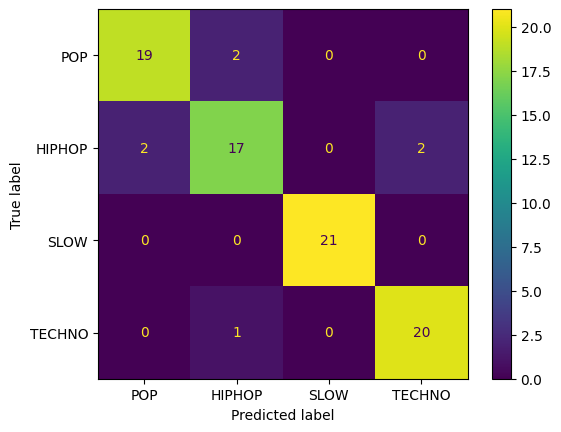

CV Accuracies Standard Deviation: 0.07715167498104596
CV Accuracies Maximum: 0.75
CV Accuracies Minimum: 1.0
CV Accuracies: [1.0, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 1.0, 0.75]
CV Mean Accuracy: 0.9166666666666666
CV F1: 0.9172676444372417


<Axes: ylabel='Feature'>

<Figure size 1500x1500 with 0 Axes>

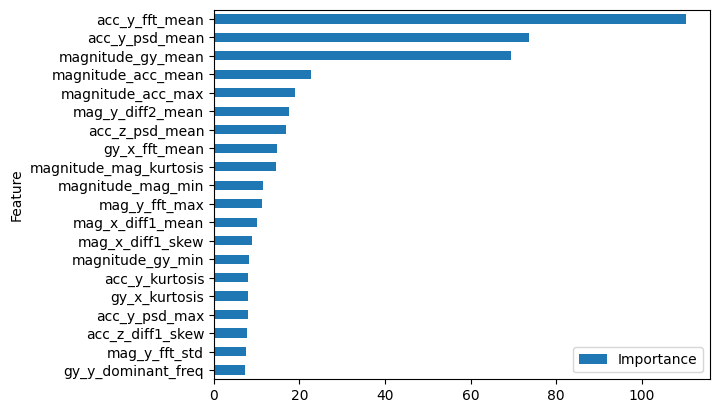

In [22]:
conf_mat = confusion_matrix(true_labels,preds_all)



disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=['POP','HIPHOP','SLOW','TECHNO'])
disp.plot()
plt.show()

print(f"CV Accuracies Standard Deviation: {np.std(avg_acc)}")
print(f"CV Accuracies Maximum: {np.min(avg_acc)}")
print(f"CV Accuracies Minimum: {np.max(avg_acc)}")
print(f"CV Accuracies: {avg_acc}")
print(f"CV Mean Accuracy: {accuracy_score(preds_all,true_labels)}")
print(f"CV F1: {f1_score(preds_all,true_labels,average='weighted')}")


importance_df = []
for m in models:
    df = pd.DataFrame({'Feature':m.feature_name_,'Importance':m.feature_importances_})
    importance_df.append(df)
    
importance_df = pd.concat(importance_df).groupby('Feature').mean().reset_index().sort_values('Importance')

plt.figure(figsize=(15, 15))
importance_df.tail(20).plot.barh(x='Feature', y='Importance')

In [ ]:
'''def get_windows(x,window_size):
    window_list = []
    for idx in np.arange(window_size,len(x),step=window_size):
        window_list.append(x[idx-window_size:idx])
    return window_list
    
    for col in sensor_cols:
        data_list[col] = data_list[col].apply(lambda x: get_windows(x,300))

    data_list = data_list.explode(sensor_cols)
    '''